### Setting up the kaggle & Downloading the Google Scrapped Dataset and Creating the .tfRecord file

#### Ref : 
https://github.com/jlaihong/Speed-up-TensorFlow-code-using-TFRecords/blob/main/2_using_TFRecords_and_pipelines.ipynb

In [ ]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle

In [3]:
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d duttadebadri/image-classification

 99% 2.33G/2.34G [00:30<00:00, 93.0MB/s]
100% 2.34G/2.34G [00:30<00:00, 82.9MB/s]


In [6]:
!mkdir gcImage

In [ ]:
!unzip image-classification.zip -d gcImage

In [ ]:
# installing tensorflow-io
!pip install tensorflow-io

     |████████████████████████████████| 23.1 MB 1.2 MB/s 


### Importing the Libs

In [18]:
import os
import io
import glob
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
import skimage
from PIL import Image
from skimage.io import imread, imshow, imread_collection, concatenate_images,imsave
from skimage.transform import resize
from skimage.util import crop, pad
from skimage.morphology import label
from skimage.color import rgb2gray, gray2rgb, rgb2lab, lab2rgb
from sklearn.model_selection import train_test_split

from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.models import Model, load_model,Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Dense, UpSampling2D, RepeatVector, Reshape
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

import tensorflow as tf

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Creating the gc-dataset folder

In [9]:
!mkdir gc-dataset

In [10]:
# creating the train_dataset folder
!mkdir gc-dataset/train

File path to Images

In [11]:
filesPath = '/content/gcImage/images/images/travel and  adventure'
targetPath = '/content/gc-dataset/train/*.jpg'

total files count

In [12]:
print(len(os.listdir(filesPath)))

8800


Moving the required files to the gcImage folder

In [13]:
i = 0
for imgFile in os.listdir(filesPath):
    imgPath = filesPath + '/' + imgFile
    img = imread(imgPath)
    targetFile = targetPath + str(i) + '.jpg'
    imsave(targetFile, img)
    i += 1

Count of the files in te gcImage 

In [17]:
print(len(os.listdir(targetPath)))

8800


Creating the .tfRecord file

In [27]:
with tf.io.TFRecordWriter('gcImages.tfrecords') as writer:
    for imgPath in os.listdir(targetPath):
        image = Image.open(targetPath+imgPath)

        bytes_buffer = io.BytesIO()
        image.convert('RGB').save(bytes_buffer, 'JPEG')
        image_bytes = bytes_buffer.getvalue()

        bytes_feature = tf.train.Feature(bytes_list=tf.train.BytesList(value=[image_bytes]))

        example = tf.train.Example(
          features=tf.train.Features(feature={
              'image': bytes_feature,
            
          })
        )

        writer.write(example.SerializeToString())

        image.close()



---



In [23]:
image_feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string), 
    }

In [24]:
def _parse_data(unparsed_example):
    return tf.io.parse_single_example(unparsed_example, image_feature_description)

In [25]:
def _bytestring_to_pixels(parsed_example):
    byte_string = parsed_example['image']
    image = tf.io.decode_image(byte_string)
    image = tf.reshape(image, [256, 256, 3])
    return image

In [26]:
def load_and_extract_images(filepath):
    dataset = tf.data.TFRecordDataset(filepath)
    dataset = dataset.map(_parse_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(_bytestring_to_pixels, num_parallel_calls=tf.data.AUTOTUNE) # .cache()
    return dataset

In [28]:
gc_dataset = load_and_extract_images('/content/gcImages.tfrecords')

In [29]:
gc_dataset

<ParallelMapDataset shapes: (256, 256, 3), types: tf.uint8>

In [30]:
gc_dataset.take(1)

<TakeDataset shapes: (256, 256, 3), types: tf.uint8>

In [31]:
for img in gc_dataset.take(2):
    print(img)

tf.Tensor(
[[[183 147  87]
  [177 138  79]
  [178 138  77]
  ...
  [ 61  13   0]
  [ 59   6   0]
  [ 61   9   0]]

 [[143 106  51]
  [138 102  44]
  [143 102  46]
  ...
  [118  70  34]
  [ 84  34   0]
  [ 55   3   0]]

 [[101  65  15]
  [104  68  18]
  [115  75  23]
  ...
  [153 105  69]
  [113  63  26]
  [ 84  32   0]]

 ...

 [[ 71  46  26]
  [ 69  47  26]
  [ 72  47  27]
  ...
  [ 73  36   9]
  [ 69  32   5]
  [ 76  39  10]]

 [[ 56  33  15]
  [ 61  40  21]
  [ 61  38  20]
  ...
  [ 87  51  29]
  [ 88  50  29]
  [ 87  49  26]]

 [[ 41  20   1]
  [ 50  29  10]
  [ 48  27   8]
  ...
  [ 72  35  17]
  [ 71  33  14]
  [ 59  21   2]]], shape=(256, 256, 3), dtype=uint8)
tf.Tensor(
[[[39 59 83]
  [38 58 82]
  [49 70 91]
  ...
  [23 36 42]
  [21 36 43]
  [20 35 42]]

 [[44 62 84]
  [40 58 80]
  [48 66 88]
  ...
  [23 36 42]
  [21 36 43]
  [20 35 42]]

 [[55 70 91]
  [47 62 81]
  [47 62 81]
  ...
  [23 36 42]
  [22 35 43]
  [21 34 42]]

 ...

 [[14 14 16]
  [18 18 20]
  [18 19 23]
  ...
  [1

In [52]:
rgb_images = []
i = 0
for img in gc_dataset.batch(10):
    batch_imgs = img.numpy()
    print(f'Batch {i} : shape => {batch_imgs.shape}')
    rgb_images.append(batch_imgs)
    i += 1

rgb_images = np.array(rgb_images)

Batch 0 : shape => (10, 256, 256, 3)
Batch 1 : shape => (10, 256, 256, 3)
Batch 2 : shape => (10, 256, 256, 3)
Batch 3 : shape => (10, 256, 256, 3)
Batch 4 : shape => (10, 256, 256, 3)
Batch 5 : shape => (10, 256, 256, 3)
Batch 6 : shape => (10, 256, 256, 3)
Batch 7 : shape => (10, 256, 256, 3)
Batch 8 : shape => (10, 256, 256, 3)
Batch 9 : shape => (10, 256, 256, 3)
Batch 10 : shape => (10, 256, 256, 3)
Batch 11 : shape => (10, 256, 256, 3)
Batch 12 : shape => (10, 256, 256, 3)
Batch 13 : shape => (10, 256, 256, 3)
Batch 14 : shape => (10, 256, 256, 3)
Batch 15 : shape => (10, 256, 256, 3)
Batch 16 : shape => (10, 256, 256, 3)
Batch 17 : shape => (10, 256, 256, 3)
Batch 18 : shape => (10, 256, 256, 3)
Batch 19 : shape => (10, 256, 256, 3)
Batch 20 : shape => (10, 256, 256, 3)
Batch 21 : shape => (10, 256, 256, 3)
Batch 22 : shape => (10, 256, 256, 3)
Batch 23 : shape => (10, 256, 256, 3)
Batch 24 : shape => (10, 256, 256, 3)
Batch 25 : shape => (10, 256, 256, 3)
Batch 26 : shape => (1

In [40]:
  print(rgb_images.shape)

(880, 10, 256, 256, 3)


Above 2 cells might be doing things like


*   It taking the images from batch and appending the list
*   For eg. above it take 10 images in batch so there are 880 istances of images



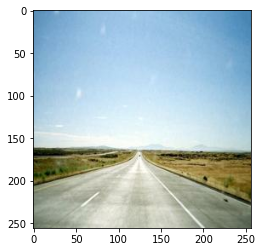

In [48]:
plt.imshow(rgb_images[0,9,:,:,:])

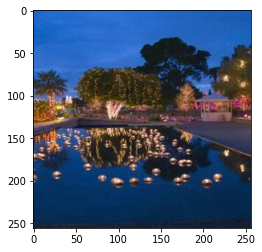

In [50]:
plt.imshow(rgb_images[1,9,:,:,:])

Hence assumption is true

### Saving the .tfRecord file in the drive

In [53]:
!cp /content/gcImages.tfrecords /content/drive/MyDrive/Test_Dataset